## Dependencies and Utils

import deps

In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import Augmentation
import albumentations as A
from augmentation.copy_paste import CopyPaste, CopyPasteAugmentation

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


Suppress some warnings

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

notebook utils

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Configuration

### Training Config

In [4]:
class DocumentsConfig(Config):
    """Configuration for training on the government document dataset.
    Derives from the base Config class and overrides values specific
    to the government document dataset.
    """
    # Give the configuration a recognizable name
    NAME = "documents"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    # TODO: add classes here
    # 1. driver licence
    NUM_CLASSES = 1 + 1  # background + 1 document type

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = DocumentsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Augmentation Definition

In [5]:
# optional: preprocess background
# pre_transform = A.Compose([
#     A.RandomSizedCrop(
#         always_apply=True, 
#         p=1.0, 
#         height=213, # crop to input size
#         width=320, # crop to input size
#         scale=(0.6, 1.0), 
#         ratio=(0.8, 1.2), 
#         interpolation=0
#     )
# ])

# define foreground augmentations
elastic_transform = A.Compose([
    A.RandomRotate90(
        always_apply=False, 
        p=0.3
    ),
    A.Rotate(
        always_apply=False, 
        p=0.9, 
        limit=(-15, 15), 
        interpolation=0, 
        border_mode=0, 
        value=(0, 0, 0), 
        mask_value=None
    ),
    A.ElasticTransform(
        always_apply=False, 
        p=0.5, 
        alpha=1.0, 
        sigma=50.0, 
        alpha_affine=10.0, 
        interpolation=0, 
        border_mode=0, 
        value=(0, 0, 0), 
        mask_value=None, 
        approximate=False
    ),
    A.OpticalDistortion(
        always_apply=False, 
        p=0.3, 
        distort_limit=(-0.3, 0.3), 
        shift_limit=(-0.05, 0.05), 
        interpolation=0, 
        border_mode=0, 
        value=(0, 0, 0), 
        mask_value=None
    )
])

# define background augmentation
pixel_transform = A.Compose(
    [
        A.RandomBrightnessContrast(
            always_apply=False, 
            p=1.0, 
            brightness_limit=(-0.2, 0.2), 
            contrast_limit=(-0.2, 0.2), 
            brightness_by_max=True
        ),
        A.GaussNoise(always_apply=False, p=0.6, var_limit=(10.0, 300)),
        A.MotionBlur(always_apply=False, p=0.1, blur_limit=(3, 7)),
        A.ToGray(always_apply=False, p=0.05),
        A.ImageCompression(
            always_apply=False, 
            p=0.8, 
            quality_lower=30, 
            quality_upper=80, 
            compression_type=0
        )
    ],
    bbox_params=A.BboxParams(
        format='pascal_voc', 
        # min_area=1024, 
        # min_visibility=0.5, 
        label_fields=['class_labels']
    )
)

### Synthetic Dataset Definition

In [6]:
# foreground objects
object_folder = Path(r'C:\Users\RN767KA\Projects\Document Classification\data\foreground\driver licence')
# background images
background_folder = Path(r'C:\Users\RN767KA\Projects\Document Classification\data\background')

# confirm access
object_folder.stat().st_mode
background_folder.stat().st_mode

16895

In [31]:
class DocumentsDataset(utils.Dataset):
    """Generates the documents synthetic dataset. The dataset consists of 
    government documents (passport, driver licence etc.) 
    placed randomly on a clean surface. The images are generated on the fly. 
    No file access required.
    """
    # background image dataset
    background_images = list(background_folder.rglob('*.jpg'))
    # TODO: the key of the map must match the foreground folder name
    # for yolo, the pairs must match the .names file
    class_mapping = {
        # 'background': 0, # default class, don't change
        'driver licence': 1,
        # 'passport': 2,
        # 'credit card': 3
    }

    def load_documents(self, count: int, object_dir: Path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        # For Single Object
        class_name = object_dir.name
        class_id = self.class_mapping[class_name]
        self.add_class("documents", class_id, class_name)

        # For Multi-objects
        # for key, value in self.class_mapping.items():
        #     self.add_class("documents", value, key) # e.g. ("documents", 1, "driver licence")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of foreground documents and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        documents_image_fps = list(object_dir.glob('*.png')) + list(object_dir.glob('*.jpg'))
        for i in range(count):
            bg_image_fp = random.choice(self.background_images)
            # add image metadata to self.image_info
            self.add_image(
                "documents", 
                image_id=i, 
                path=None,
                class_id=class_id,
                background=bg_image_fp,
                documents=documents_image_fps
            )

    def load_image_mask(self, image_id) -> Tuple[np.ndarray, np.ndarray, int]:
        '''Load synthetic image and its mask in one go by copy-paste augmentation
        '''
        info = self.image_info[image_id]
        bg_image_fp = info["background"]
        documents_image_fps = info["documents"]

        bg_image: np.ndarray = cv2.imread(str(bg_image_fp))
        height, width, channels = bg_image.shape

        # define foreground/background interaction
        overlay_background = CopyPasteAugmentation(
            source_images=documents_image_fps,
            albu_transforms=elastic_transform,
            bev_transform=None, 
            n_objects_range=[0, 2], # object count
            h_range=[0.2 * height, 0.8 * height], # object height -> size
            x_range=[0.2 * width, 0.8 * width], # x center
            y_range=[0.3 * height, 1 * height] # y bottom
        )

        count = 0
        while True:
            try:
                # overlay foreground onto background
                # TODO: split mask then concat
                result_image, result_coords, semantic_mask, instance_mask = overlay_background(bg_image)

                count = len(result_coords)
                # optionally put pixel transform into train() and replace imaug
                transformed = pixel_transform(
                    image=result_image, 
                    bboxes=result_coords,
                    mask=instance_mask,
                    class_labels=[info["class_id"]] * count,
                    # class_categories=class_categories
                )
            except Exception as e:
                print(e)
            else:
                print(count)
                break

        transformed_image = transformed['image']
        transformed_masks = []
        if count > 1:
            for i in range(count):
                transformed_masks.append(np.where(instance_mask == (i + 1), instance_mask, 0).astype(np.bool))
            transformed_mask = np.dstack(transformed_masks) # stack depth channels
        elif count == 1:
            # expand 2 dim mask to 3 dim
            transformed_mask = np.expand_dims(
                np.where(
                    instance_mask == 1, 
                    instance_mask, 0
                ).astype(np.bool), 
                axis=2
            )
        else:
            transformed_mask = np.full((height, width, 1), False)
            
        transformed_class_labels = np.array(transformed['class_labels']).astype(np.int32)

        return transformed_image, transformed_mask, transformed_class_labels

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "documents":
            class_id = info["class_id"]
            background_name = Path(info["background"]).name
            return f"document type {class_id} overlay on {background_name}"
        else:
            super(self.__class__).image_reference(self, image_id)


training & validation split

In [32]:
# Training dataset
dataset_train = DocumentsDataset()
dataset_train.load_documents(50, object_folder)
dataset_train.prepare()

# Validation dataset
dataset_val = DocumentsDataset()
dataset_val.load_documents(5, object_folder)
dataset_val.prepare()

## Inspect dataset

0


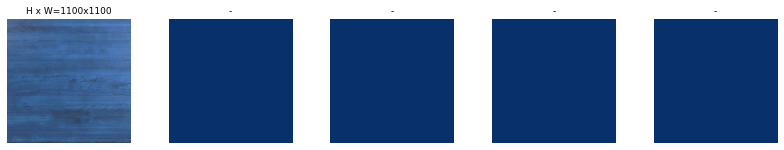

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'cv::binary_op'

1


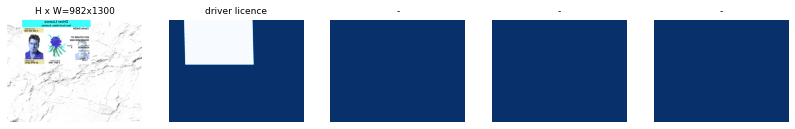

0


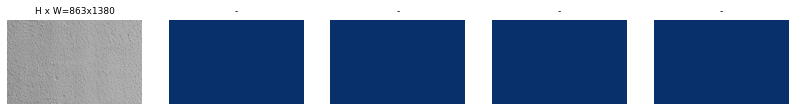

1


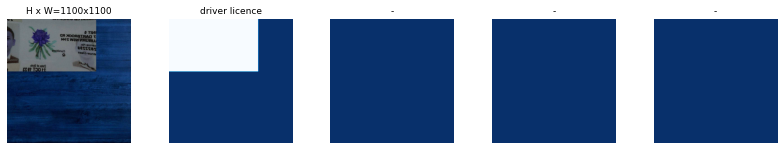

In [36]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image, mask, class_ids = dataset_train.load_image_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(
        COCO_MODEL_PATH, 
        by_name=True, 
        exclude=[
          "mrcnn_class_logits", 
          "mrcnn_bbox_fc",
          "mrcnn_bbox", 
          "mrcnn_mask"
        ]
    )
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=5,
    layers='heads'
)

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(DocumentsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Select a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    dataset_val, 
    inference_config,
    use_mini_mask=False
)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image, gt_bbox,
    gt_mask, gt_class_id,
    dataset_train.class_names,
    figsize=(8, 8)
)

In [ ]:
# Test on the selected image
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(
    original_image,
    r['rois'],
    r['masks'],
    r['class_ids'],
    dataset_val.class_names,
    r['scores'],
    ax=get_ax()
  )

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))